## 1차 과제 - 고객 유지/이탈 자유 분석
- 주제: 가입 고객 이탈 데이터를 분석하여 기업에 인사이트 제공
- 데이터: Customer Churn Data(train data가 따로 있으나 너무 커서 test data만 사용, 예측 성능 향상을 원한다면 train data 사용해도 무방)
https://www.kaggle.com/datasets/muhammadshahidazeem/customer-churn-dataset?select=customer_churn_dataset-training-master.csv
- 사용 라이브러리: 자유

본 과제는 여러분들의 실력을 확인하고자 출제한 과제로 어떠한 가이드라인도 제공하거나 제약하지 않으며 자유롭게 분석하시면 됩니다.

분석이나 예측 어느 쪽이든 상관없으며 몇가지 조건만 유의하여 주시기 바랍니다.

### 조건
1. 기본적인 분석 과정은 EDA(데이터 탐색) > 전처리 > 분석(예측) 진행 > 결과 해석 으로 진행되지만 약간의 수정 허용
2. EDA 과정에서 최소 2개의 시각화 모형(그래프) 사용
3. 분석 및 예측 시 최소 2개의 모형(모델) 사용
4. 전처리는 자유롭게 진행하며 추가적인 데이터 사용이 필요하다면 허용

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier

import optuna

from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [43]:
df = pd.read_csv('C:/Users/KimDongyoung/Desktop/my_git/mygit/DAT/24-2/개인과제/data/customer_churn_dataset-testing-master.csv')

In [44]:
df['Subscription Type'].unique()

array(['Basic', 'Standard', 'Premium'], dtype=object)

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64374 entries, 0 to 64373
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   CustomerID         64374 non-null  int64 
 1   Age                64374 non-null  int64 
 2   Gender             64374 non-null  object
 3   Tenure             64374 non-null  int64 
 4   Usage Frequency    64374 non-null  int64 
 5   Support Calls      64374 non-null  int64 
 6   Payment Delay      64374 non-null  int64 
 7   Subscription Type  64374 non-null  object
 8   Contract Length    64374 non-null  object
 9   Total Spend        64374 non-null  int64 
 10  Last Interaction   64374 non-null  int64 
 11  Churn              64374 non-null  int64 
dtypes: int64(9), object(3)
memory usage: 5.9+ MB


Churn = Target Variable 

0: 이탈 x, 1: 이탈 o

## EDA

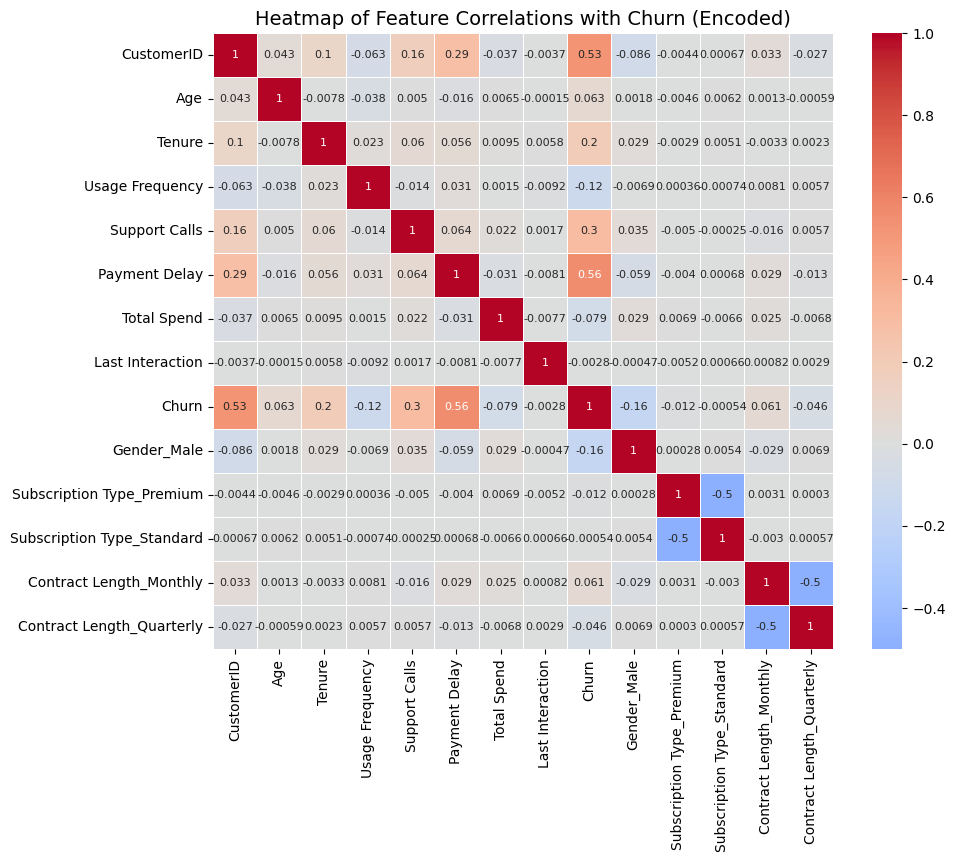

In [47]:
# object 타입인 컬럼을 원핫인코딩을 사용해서 타입을 변환
df_encoded = pd.get_dummies(df, columns=['Gender', 'Subscription Type', 'Contract Length'], drop_first=True)

# 히트맵을 사용해 상관관계 분석
corr_matrix_encoded = df_encoded.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_encoded, annot=True, cmap='coolwarm', center=0, linewidths=0.5, annot_kws={"size": 8})
plt.title('Heatmap of Feature Correlations with Churn (Encoded)', fontsize=14)
plt.show()

Target variable인 Churn 컬럼과 상관계수가 높은 변수는 Payment Delay, CustomerID, Support Calls, Tenure 변수였다. 이 변수들은 모두 Churn 변수와 양의 상관관계를 보였다.

Gender_Male 변수는 -0.16으로 Churn 변수와 음의 상관관계를 보였다. 다른 나머지 변수들은 Churn 변수와 뚜렷한 무언가가 보이지 않았다.

In [48]:
df['Payment Delay'].unique()

array([27, 13, 29, 17,  2, 10, 28, 18,  8, 23, 21, 14, 25,  3,  6, 15,  1,
        9, 30,  4,  0, 11, 16,  7, 24, 22, 12, 26, 20, 19,  5],
      dtype=int64)

In [49]:
def calculate_churn_ratio(variable, df_encoded):
    """
    Function to calculate and display the ratio of churn based on a given variable.
    
    Args:
    variable (str): The variable to analyze churn against.
    df_encoded (DataFrame): The dataset with encoded categorical values.
    
    Returns:
    None
    """
    # Calculate the ratio of the target variable 'Churn' for each unique value of the variable
    target_distribution = df_encoded.groupby(variable)['Churn'].value_counts(normalize=True).unstack(fill_value=0)
    
    # Output the result
    print(f"Ratio of target variable (Churn) according to {variable}:")
    print(target_distribution)
    print("\n")

# Test the function with 'Tenure' variable
calculate_churn_ratio('Tenure', df_encoded)

Ratio of target variable (Churn) according to Tenure:
Churn          0         1
Tenure                    
1       0.637728  0.362272
2       0.646745  0.353255
3       0.665984  0.334016
4       0.653445  0.346555
5       0.656670  0.343330
6       0.695421  0.304579
7       0.682318  0.317682
8       0.701754  0.298246
9       0.728070  0.271930
10      0.693391  0.306609
11      0.694416  0.305584
12      0.728462  0.271538
13      0.722644  0.277356
14      0.716854  0.283146
15      0.718750  0.281250
16      0.735199  0.264801
17      0.703507  0.296493
18      0.707127  0.292873
19      0.721560  0.278440
20      0.717660  0.282340
21      0.718519  0.281481
22      0.680511  0.319489
23      0.719280  0.280720
24      0.436752  0.563248
25      0.448927  0.551073
26      0.456095  0.543905
27      0.436508  0.563492
28      0.441475  0.558525
29      0.444631  0.555369
30      0.419301  0.580699
31      0.450963  0.549037
32      0.444934  0.555066
33      0.460432  0.539568
3

Tenure의 경우 23까지는 이탈률이 30% 근처였으나 24 이후부터는 이탈률이 50%를 초과하였다.

In [50]:
calculate_churn_ratio('Payment Delay', df_encoded)

Ratio of target variable (Churn) according to Payment Delay:
Churn                 0         1
Payment Delay                    
0              0.904015  0.095985
1              0.904483  0.095517
2              0.883736  0.116264
3              0.892417  0.107583
4              0.901763  0.098237
5              0.901786  0.098214
6              0.911746  0.088254
7              0.892138  0.107862
8              0.901219  0.098781
9              0.895698  0.104302
10             0.902795  0.097205
11             0.894902  0.105098
12             0.902962  0.097038
13             0.900498  0.099502
14             0.894314  0.105686
15             0.898487  0.101513
16             0.420652  0.579348
17             0.403937  0.596063
18             0.420315  0.579685
19             0.417072  0.582928
20             0.410088  0.589912
21             0.227766  0.772234
22             0.238213  0.761787
23             0.221649  0.778351
24             0.242722  0.757278
25             0.2322

Payment Delay의 경우에는 Delay되는 날이 길어질 수록 이탈률이 증가하는 것을 알 수 있었다.

In [51]:
calculate_churn_ratio('Gender_Male', df_encoded)

Ratio of target variable (Churn) according to Gender_Male:
Churn               0         1
Gender_Male                    
False        0.449510  0.550490
True         0.614203  0.385797




성별에 따라 이탈율이 상이한 것을 알 수 있었다. 여성의 경우 이탈률이 50% 이상이었고 남성의 경우 이탈률이 50% 이하였다.

In [52]:
calculate_churn_ratio('Support Calls', df_encoded)

Ratio of target variable (Churn) according to Support Calls:
Churn                 0         1
Support Calls                    
0              0.757801  0.242199
1              0.771150  0.228850
2              0.768495  0.231505
3              0.751641  0.248359
4              0.681624  0.318376
5              0.395373  0.604627
6              0.393885  0.606115
7              0.382179  0.617821
8              0.390435  0.609565
9              0.390906  0.609094
10             0.393047  0.606953




Support calls 변수의 경우 0~3까지 이탈률이 25% 미만이었으나 4로 올라가니 이탈률이 31.8%를 기록했고 5~10까지는 이탈률이 60%를 초과했다.

In [53]:
# # Define the function without using external tools
# def calculate_churn_ratio_by_two_vars(var1, var2, df_encoded):
#     """
#     Function to calculate and display the churn rate based on two variables.
    
#     Args:
#     var1 (str): The first variable to group by.
#     var2 (str): The second variable to group by.
#     df_encoded (DataFrame): The dataset with encoded categorical values.
    
#     Returns:
#     None
#     """
#     # Group by the two variables and calculate the churn rate
#     churn_ratio = df_encoded.groupby([var1, var2])['Churn'].value_counts(normalize=True).unstack(fill_value=0)
    
#     # Output the result using print
#     print(f"Churn Ratio by {var1} and {var2}:")
#     print(churn_ratio)

# calculate_churn_ratio_by_two_vars('Gender_Male', 'Payment Delay', df_encoded)


## Preprocessing

범주 변주화

In [54]:
df_encoded['Tenure_Group'] = pd.cut(df_encoded['Tenure'], bins=[0, 5, 23, 60], labels=['1-5', '6-23', '24-60'])
df_encoded['Payment_Delay_Group'] = pd.cut(df_encoded['Payment Delay'], bins=[0, 15, 20, 30], labels=['0-15', '16-20', '21-30'])
df_encoded['Support_Calls_Group'] = pd.cut(df_encoded['Support Calls'], bins=[0, 3, 4, 10], labels=['0-3', '4', '5-10'])


# Display the first few rows to confirm the new grouping
df_encoded[['Tenure', 'Tenure_Group']].head()
# Display the first few rows to confirm the new grouping
df_encoded[['Support Calls', 'Support_Calls_Group']].head()
# Display the first few rows to confirm the new grouping
df_encoded[['Payment Delay', 'Payment_Delay_Group']].head()



,Payment Delay,Payment_Delay_Group
0,27,21-30
1,13,0-15
2,29,21-30
3,17,16-20
4,2,0-15


Target encoding

In [55]:
# Perform target encoding for the grouped variables based on the mean of the target variable 'Churn'

# Define a function to perform target encoding
def target_encode(df, variable, target):
    """
    Function to perform target encoding on a categorical variable based on the mean of the target variable.
    
    Args:
    df (DataFrame): The dataset.
    variable (str): The categorical variable to encode.
    target (str): The target variable to calculate the mean for encoding.
    
    Returns:
    Series: The target encoded values.
    """
    # Calculate the mean of the target variable for each category in the variable
    means = df.groupby(variable)[target].mean()
    
    # Map the mean values back to the original dataframe
    return df[variable].map(means)

# Apply target encoding to the grouped variables
df_encoded['Tenure_Group_Encoded'] = target_encode(df_encoded, 'Tenure_Group', 'Churn')
df_encoded['Payment_Delay_Group_Encoded'] = target_encode(df_encoded, 'Payment_Delay_Group', 'Churn')
df_encoded['Support_Calls_Group_Encoded'] = target_encode(df_encoded, 'Support_Calls_Group', 'Churn')

# Display the first few rows to confirm the encoding
df_encoded[['Tenure_Group', 'Tenure_Group_Encoded', 'Payment_Delay_Group', 'Payment_Delay_Group_Encoded', 'Support_Calls_Group', 'Support_Calls_Group_Encoded']].head()


C:\Users\KimDongyoung\AppData\Local\Temp\ipykernel_24956\3075437488.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df.groupby(variable)[target].mean()
C:\Users\KimDongyoung\AppData\Local\Temp\ipykernel_24956\3075437488.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df.groupby(variable)[target].mean()
C:\Users\KimDongyoung\AppData\Local\Temp\ipykernel_24956\3075437488.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default a

,Tenure_Group,Tenure_Group_Encoded,Payment_Delay_Group,Payment_Delay_Group_Encoded,Support_Calls_Group,Support_Calls_Group_Encoded
0,24-60,0.559247,21-30,0.765960,4,0.318376
1,24-60,0.559247,0-15,0.101374,5-10,0.609021
2,24-60,0.559247,21-30,0.765960,0-3,0.236103
3,6-23,0.289956,16-20,0.585597,5-10,0.609021
4,24-60,0.559247,0-15,0.101374,5-10,0.609021


In [56]:
columns_to_drop = ['CustomerID','Tenure','Tenure_Group','Payment Delay','Payment_Delay_Group',
                   'Support Calls','Support_Calls_Group','Total Spend','Last Interaction',
                   'Subscription Type_Premium', 'Contract Length_Quarterly']

data = df_encoded.drop(columns=columns_to_drop)

In [57]:
# Loop through all columns, and if the column's dtype is 'category', try converting it to float only if the values are numeric
for col in data.columns:
    if data[col].dtype.name == 'category':
        # Check if the values can be converted to float by testing if they are numeric
        try:
            data[col] = data[col].astype(float)
        except ValueError:
            # If conversion fails, skip the column
            print(f"Skipping non-numeric category column: {col}")

In [58]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64374 entries, 0 to 64373
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Age                          64374 non-null  int64  
 1   Usage Frequency              64374 non-null  int64  
 2   Churn                        64374 non-null  int64  
 3   Gender_Male                  64374 non-null  bool   
 4   Subscription Type_Standard   64374 non-null  bool   
 5   Contract Length_Monthly      64374 non-null  bool   
 6   Tenure_Group_Encoded         64374 non-null  float64
 7   Payment_Delay_Group_Encoded  62780 non-null  float64
 8   Support_Calls_Group_Encoded  59407 non-null  float64
dtypes: bool(3), float64(3), int64(3)
memory usage: 3.1 MB


## Modeling

train_data, test_data split

In [61]:
# 전체 데이터 중 10%를 test_data로 활용
split_index = int(len(data) * 0.9)

train_data = data[:split_index]
test_data = data[split_index:]

# Display the shapes of the resulting datasets to verify the split
train_data.shape, test_data.shape

((57936, 9), (6438, 9))

In [ ]:
RANDOM_STATE = 110

# 스레드홀드 설정
THRESHOLD = 0.5

def objectiveXGB(trial, x_tr, y_tr, x_val, y_val):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 1200, 3000)
        , 'learning_rate': trial.suggest_float('learning_rate', 0.002, 0.2)
        , 'max_depth': trial.suggest_int('max_depth', 3, 25)

        , 'alpha': trial.suggest_float('alpha', 0.00001, 0.01, log=True)
        , 'gamma': trial.suggest_float('gamma', 0.00001, 0.01, log=True)

        , 'reg_alpha' : trial.suggest_float('reg_alpha', 0.3, 1)
        , 'reg_lambda' : trial.suggest_float('reg_lambda', 0.5, 1)
        
        , 'colsample_bytree' : trial.suggest_float('colsample_bytree', 0.5, 1)
        , 'subsample' : trial.suggest_float('subsample', 0.1, 1)
        , 'objective': 'binary:logistic'  # 이진 분류
        , 'tree_method' : "exact"        
        , 'random_state': RANDOM_STATE
    }
       
    model = XGBClassifier(**param)
    model.fit(x_tr, y_tr)
    pred_proba = model.predict_proba(x_val)[:, 1]  # 양성 클래스 확률
    pred = (pred_proba >= THRESHOLD).astype(int)  # 스레드홀드에 따른 예측
    
    score = f1_score(y_val, pred, average="binary")
    
    return score

# 데이터셋 분할
x_train, x_val, y_train, y_val = train_test_split(
    train_data.drop("Churn", axis=1),
    train_data["Churn"],
    test_size=0.2,
    shuffle=True,
    random_state=RANDOM_STATE,
)

# 하이퍼 파라미터 튜닝
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE))
study.optimize(lambda trial: objectiveXGB(trial, x_train, y_train, x_val, y_val), n_trials=100)

print('Best trial: score {}, \nparams {}'.format(study.best_trial.value, study.best_trial.params))


In [85]:
# Model instantiation
model = XGBClassifier()

# Hyperparameters for the model (to be set later)
model.set_params(
    n_estimators=2358, 
    learning_rate=0.0027464525711571215, 
    max_depth=19, 
    alpha=0.0016813104047994985, 
    gamma=0.00017000062708485094, 
    reg_alpha=0.8448041863443291, 
    reg_lambda=0.6273912941169697, 
    colsample_bytree=0.8713055958707755, 
    subsample=0.3650627017922281,
    objective='binary:logistic',  # Binary classification
    tree_method="exact", 
    random_state=42
)


XGBClassifier(alpha=0.0016813104047994985, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8713055958707755, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None,
              gamma=0.00017000062708485094, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.0027464525711571215, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=19, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=2358, n_jobs=None,
              num_parallel_tree=None, ...)

In [86]:
# Function to train and evaluate the model
def train_and_evaluate_model(model, data):
    # Split the data into training and validation sets
    x_train, x_val, y_train, y_val = train_test_split(
        data.drop("Churn", axis=1),
        data["Churn"],
        test_size=0.2,
        shuffle=True,
        random_state=RANDOM_STATE,
    )

    # Train the model
    model.fit(x_train, y_train)

    # Predict on the validation set
    y_val_pred_proba = model.predict_proba(x_val)[:, 1]  # Positive class probabilities
    y_val_pred = (y_val_pred_proba >= THRESHOLD).astype(int)  # Threshold-based predictions

    # Calculate evaluation metrics
    f1 = f1_score(y_val, y_val_pred, average="binary")
    accuracy = accuracy_score(y_val, y_val_pred)
    precision = precision_score(y_val, y_val_pred)
    recall = recall_score(y_val, y_val_pred)
    conf_matrix = confusion_matrix(y_val, y_val_pred)
    
    # Print the results
    print(f'F1 Score: {f1}')
    print('---')
    print('Confusion Matrix:')
    print(conf_matrix)
    print('---')
    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print('\n')

# Train and evaluate the model on train_data
train_and_evaluate_model(model, train_data)

F1 Score: 0.904731320916292
---
Confusion Matrix:
[[6472  353]
 [ 537 4226]]
---
Accuracy: 0.9231964100793925
Precision: 0.9229089320812405
Recall: 0.8872559311358388




In [90]:
# Test data prediction and evaluation
x_test = test_data.drop(["Churn"], axis=1)
y_test = test_data['Churn']

# Predict on the test data
y_test_pred_proba = model.predict_proba(x_test)[:, 1]  # Positive class probabilities
y_test_pred = (y_test_pred_proba >= 0.5).astype(int)  

# Calculate F1 score and confusion matrix for the test data
f1_test = f1_score(y_test, y_test_pred)
conf_matrix_test = confusion_matrix(y_test, y_test_pred)

# f1 score 및 confusion matrix 출력
print(f'Test F1 Score: {f1_test}')
print('Test Confusion Matrix:')
print(conf_matrix_test)

Test F1 Score: 0.9379742659188387
Test Confusion Matrix:
[[   0    0]
 [ 752 5686]]
